In [2]:
!pip install -q surprise

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate


import warnings; warnings.simplefilter('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
md = pd.read_csv('/content/gdrive/My Drive/DATA/movie/movies_metadata.csv')

In [5]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [6]:
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [7]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [8]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

# TOP-N Movies

In [9]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')

In [11]:
C = vote_averages.mean()

In [12]:
C

5.244896612406511

In [13]:
m = vote_counts.quantile(0.95)

In [14]:
m

434.0

In [15]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())]
qualified.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2274 entries, 0 to 45014
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  2274 non-null   object 
 1   belongs_to_collection  771 non-null    object 
 2   budget                 2274 non-null   object 
 3   genres                 2274 non-null   object 
 4   homepage               1187 non-null   object 
 5   id                     2274 non-null   object 
 6   imdb_id                2274 non-null   object 
 7   original_language      2274 non-null   object 
 8   original_title         2274 non-null   object 
 9   overview               2274 non-null   object 
 10  popularity             2274 non-null   object 
 11  poster_path            2274 non-null   object 
 12  production_companies   2274 non-null   object 
 13  production_countries   2274 non-null   object 
 14  release_date           2274 non-null   object 
 15  rev

In [16]:
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 25)

In [17]:
def weighted_rating(x, C=C, m=m):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [18]:
qualified['wr'] = qualified.apply(weighted_rating, axis = 1)

In [19]:
qualified = qualified[['imdb_id', 'title', 'wr']]

In [20]:
qualified = qualified.sort_values('wr', ascending = False)

In [21]:
qualified.head(10)

,imdb_id,title,wr
15480,tt1375666,Inception,7.917588
12481,tt0468569,The Dark Knight,7.905871
22879,tt0816692,Interstellar,7.897107
2843,tt0137523,Fight Club,7.881753
4863,tt0120737,The Lord of the Rings: The Fellowship of the Ring,7.871787
292,tt0110912,Pulp Fiction,7.868660
314,tt0111161,The Shawshank Redemption,7.864000
7000,tt0167260,The Lord of the Rings: The Return of the King,7.861927
351,tt0109830,Forrest Gump,7.860656
5814,tt0167261,The Lord of the Rings: The Two Towers,7.851924


In [22]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)

In [23]:
s.name = 'genre'

In [24]:
s.head(20)

0    Animation
0       Comedy
0       Family
1    Adventure
1      Fantasy
1       Family
2      Romance
2       Comedy
3       Comedy
3        Drama
3      Romance
4       Comedy
5       Action
5        Crime
5        Drama
5     Thriller
6       Comedy
6      Romance
7       Action
7    Adventure
Name: genre, dtype: object

In [25]:
gen_md = md.drop('genres', axis=1).join(s)

In [26]:
gen_md.dropna(subset=['genre'], inplace=True)

In [27]:
gen_md.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91106 entries, 0 to 45463
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  91106 non-null  object 
 1   belongs_to_collection  11094 non-null  object 
 2   budget                 91106 non-null  object 
 3   homepage               16373 non-null  object 
 4   id                     91106 non-null  object 
 5   imdb_id                91076 non-null  object 
 6   original_language      91090 non-null  object 
 7   original_title         91106 non-null  object 
 8   overview               90033 non-null  object 
 9   popularity             91089 non-null  object 
 10  poster_path            90841 non-null  object 
 11  production_companies   91097 non-null  object 
 12  production_countries   91097 non-null  object 
 13  release_date           91048 non-null  object 
 14  revenue                91085 non-null  float64
 15  ru

In [28]:
gen_md.head()

,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Family
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Adventure
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Fantasy


In [29]:
def genre_top(genre, percentile, top):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile) 
    TOP_N = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    TOP_N['vote_count'] = TOP_N['vote_count'].astype('int')
    TOP_N['vote_average'] = TOP_N['vote_average'].astype('int')
    
    TOP_N['wr'] = TOP_N.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    TOP_N.sort_values('wr', ascending=False).head(100)

    return TOP_N.head(top)


TOP 10 Horror Movies

In [30]:
top10_horror = genre_top('Horror', 0.85, 10)

In [31]:
top10_horror

,title,year,vote_count,vote_average,popularity,wr
11,Dracula: Dead and Loving It,1995,210,5,5.430331,4.927529
69,From Dusk Till Dawn,1996,1644,6,15.339153,5.916173
75,Screamers,1995,154,6,12.758848,5.466887
185,The Prophecy,1995,139,6,10.187623,5.436481
193,Species,1995,457,5,13.492845,4.958338
249,Interview with the Vampire,1994,1558,7,11.970205,6.838166
269,Mary Shelley's Frankenstein,1994,272,6,14.287753,5.625744
327,Village of the Damned,1995,165,5,6.529879,4.916244
361,New Nightmare,1994,297,6,9.860522,5.647968
402,In the Mouth of Madness,1994,307,7,8.497643,6.368433


TOP 10 Romance Movies

In [32]:
top10_romance = genre_top('Romance', 0.85, 10)
top10_romance


,title,year,vote_count,vote_average,popularity,wr
2,Grumpier Old Men,1995,92,6,11.7129,5.703870
6,Sabrina,1995,141,6,6.677277,5.766442
10,The American President,1995,199,6,6.318445,5.813170
16,Sense and Sensibility,1995,364,7,10.673167,6.681112
24,Leaving Las Vegas,1995,365,7,10.332025,6.681812
37,It Takes Two,1995,149,6,7.777735,5.774231
38,Clueless,1995,828,6,9.882383,5.941058
51,Mighty Aphrodite,1995,145,6,15.899134,5.770402
57,The Postman,1994,181,7,10.168437,6.466487
91,Vampire in Brooklyn,1995,113,4,9.071127,4.625983


TOP 10 Action Movies

In [33]:
top10_action = genre_top('Action', 0.85, 10)
top10_action

,title,year,vote_count,vote_average,popularity,wr
5,Heat,1995,1886,7,17.924927,6.803544
9,GoldenEye,1995,1194,6,14.686036,5.867653
22,Assassins,1995,394,6,11.065939,5.697171
43,Mortal Kombat,1995,452,5,10.870138,5.057401
69,From Dusk Till Dawn,1996,1644,6,15.339153,5.899483
93,Broken Arrow,1996,459,5,14.957626,5.056815
108,Braveheart,1995,3404,7,20.755149,6.885674
110,Rumble in the Bronx,1995,245,6,12.314278,5.601584
142,Bad Boys,1995,1729,6,9.262184,5.903851
150,Batman Forever,1995,1529,5,13.321354,5.022196


Trading Now

In [34]:
md['popularity'].fillna('0', inplace = True)

In [35]:
md['popularity'].isna().sum()

0

In [36]:
md['popularity'] = pd.to_numeric(md['popularity'], errors='coerce')

In [37]:
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45465 non-null  float64
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [38]:
trend = md.sort_values('popularity', ascending=False)

Text(0.5, 1.0, 'Popular Movies')

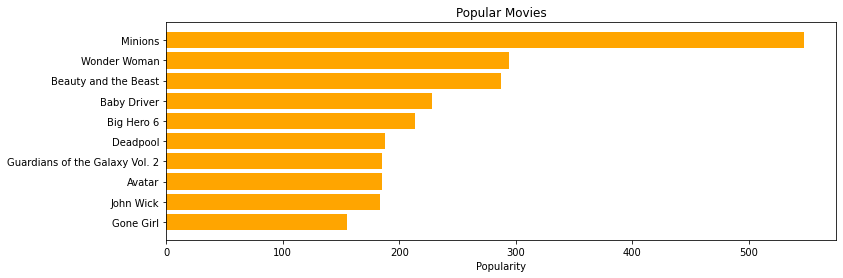

In [39]:
plt.figure(figsize=(12,4))

plt.barh(trend['title'].head(10),trend['popularity'].head(10), align='center',color='orange')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

## Content Based Filtering

This Content Based Recommenders based on:
1. Movie overview and taglines
2. Movie Case, Crew, Keywords and Genre

In [40]:
links_small = pd.read_csv('/content/gdrive/My Drive/DATA/movie/links_small.csv')

In [41]:
links = pd.read_csv('/content/gdrive/My Drive/DATA/movie/links.csv')

In [42]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  45843 non-null  int64  
 1   imdbId   45843 non-null  int64  
 2   tmdbId   45624 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.0 MB


In [43]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [44]:
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45465 non-null  float64
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [45]:
md = md.drop([19730, 29503, 35587])

In [46]:
md['id'] = md['id'].astype('int')

In [47]:
md['tagline'] = md['tagline'].fillna('')

In [48]:
md['tagline']

0                                                         
1                Roll the dice and unleash the excitement!
2        Still Yelling. Still Fighting. Still Ready for...
3        Friends are the people who let you be yourself...
4        Just When His World Is Back To Normal... He's ...
                               ...                        
45461           Rising and falling between a man and woman
45462                                                     
45463                               A deadly game of wits.
45464                                                     
45465                                                     
Name: tagline, Length: 45463, dtype: object

In [49]:
md['tagline'].isnull().sum()

0

In [50]:
md['overview']

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
45461          Rising and falling between a man and woman.
45462    An artist struggles to finish his work while a...
45463    When one of her hits goes wrong, a professiona...
45464    In a small town live two brothers, one a minis...
45465    50 years after decriminalisation of homosexual...
Name: overview, Length: 45463, dtype: object

In [51]:
md['overview'] = md['overview'].fillna('')

In [52]:
md['overview'].isnull().sum()

0

In [53]:
md['description'] = md['tagline'] + md['overview']

In [54]:
md['description']

0        Led by Woody, Andy's toys live happily in his ...
1        Roll the dice and unleash the excitement!When ...
2        Still Yelling. Still Fighting. Still Ready for...
3        Friends are the people who let you be yourself...
4        Just When His World Is Back To Normal... He's ...
                               ...                        
45461    Rising and falling between a man and womanRisi...
45462    An artist struggles to finish his work while a...
45463    A deadly game of wits.When one of her hits goe...
45464    In a small town live two brothers, one a minis...
45465    50 years after decriminalisation of homosexual...
Name: description, Length: 45463, dtype: object

In [55]:
md = md.drop_duplicates(subset='title', keep="first")

In [56]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(md['description'])

In [57]:
tfidf_matrix[0]

<1x1046048 sparse matrix of type '<class 'numpy.float64'>'
	with 55 stored elements in Compressed Sparse Row format>

In [58]:
tfidf_matrix.shape

(42278, 1046048)

Cosine Similarity

In [59]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [60]:
cosine_sim[0]

array([1.        , 0.00525604, 0.        , ..., 0.        , 0.00238306,
       0.        ])

In [61]:
md = md.reset_index()

In [62]:
titles = md['title']

In [63]:
indices = pd.Series(md.index, index=md['title'])

In [64]:
indices

title
Toy Story                          0
Jumanji                            1
Grumpier Old Men                   2
Waiting to Exhale                  3
Father of the Bride Part II        4
                               ...  
Caged Heat 3000                42273
Subdue                         42274
Century of Birthing            42275
Satan Triumphant               42276
Queerama                       42277
Length: 42278, dtype: int64

In [65]:
indices['Iron Man']

12177

In [66]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [67]:
get_recommendations('The Godfather').head(10)

40983    The Godfather Trilogy: 1972-1990
1176               The Godfather: Part II
29998                    Honor Thy Father
21970                          Blood Ties
35503            A Mother Should Be Loved
17533                     The Outside Man
10957                    Household Saints
4278                                 Made
5359                   Johnny Dangerously
17445                           Miss Bala
Name: title, dtype: object

In [69]:
get_recommendations('The Prestige').head(10)

38430             Miss Sharon Jones!
36212                     Fast Girls
14175    Mega Shark vs Giant Octopus
39366     Thank You for Your Service
31284                A Bigger Splash
4912                            Cows
2710                      Nightmares
10570     Urban Legends: Bloody Mary
7698                        Rapa Nui
29743                      Roadblock
Name: title, dtype: object

In [70]:
get_recommendations('Iron Man').head(10)

19861                          Iron Man 3
19826             The Invincible Iron Man
14587                          Iron Man 2
27386                               Jocks
35762      Fatal Fury: The Motion Picture
38179                     Girl in the Box
25061             Avengers: Age of Ultron
26948                               Clown
14630    The Disappearance of Alice Creed
7411         The Wonderful Ice Cream Suit
Name: title, dtype: object

In [71]:
credits = pd.read_csv('/content/gdrive/My Drive/DATA/movie/credits.csv')

In [72]:
keywords = pd.read_csv('/content/gdrive/My Drive/DATA/movie/keywords.csv')

In [73]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [74]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


In [75]:
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42278 entries, 0 to 42277
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  42278 non-null  int64  
 1   adult                  42278 non-null  object 
 2   belongs_to_collection  4358 non-null   object 
 3   budget                 42278 non-null  object 
 4   genres                 42278 non-null  object 
 5   homepage               7241 non-null   object 
 6   id                     42278 non-null  int64  
 7   imdb_id                42262 non-null  object 
 8   original_language      42267 non-null  object 
 9   original_title         42278 non-null  object 
 10  overview               42278 non-null  object 
 11  popularity             42278 non-null  float64
 12  poster_path            41906 non-null  object 
 13  production_companies   42277 non-null  object 
 14  production_countries   42277 non-null  object 
 15  re

In [76]:
md['id'] = md['id'].astype('int')

In [77]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [78]:
md['cast'] = md['cast'].apply(literal_eval)
md['crew'] = md['crew'].apply(literal_eval)
md['keywords'] = md['keywords'].apply(literal_eval)
md['cast_size'] = md['cast'].apply(lambda x: len(x))
md['crew_size'] = md['crew'].apply(lambda x: len(x))

In [79]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [80]:
md['director'] = md['crew'].apply(get_director)

In [81]:
md['cast'] = md['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
md['cast'] = md['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [82]:
md['keywords'] = md['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [83]:
md['cast'] = md['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
md['director'] = md['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
md['director'] = md['director'].apply(lambda x: [x,x, x])

In [84]:
s = md.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [85]:
s = s.value_counts()
s[:5]

woman director      2899
independent film    1840
murder              1183
based on novel       746
musical              683
Name: keyword, dtype: int64

In [86]:
s = s[s > 1]

In [87]:
stemmer = SnowballStemmer('english')

In [88]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [89]:
md['keywords'] = md['keywords'].apply(filter_keywords)
md['keywords'] = md['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
md['keywords'] = md['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [90]:
md['soup'] = md['keywords'] + md['cast'] + md['director'] + md['genres']
md['soup'] = md['soup'].apply(lambda x: ' '.join(x))

In [91]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(md['soup'])

In [ ]:
cosine_sim_m = cosine_similarity(count_matrix, count_matrix)

In [ ]:
titles = md['title']
indices = pd.Series(md.index, index=md['title'])

In [ ]:
get_recommendations('Mean Girls').head(10)


In [ ]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_m[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = md.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [ ]:
improved_recommendations('Mean Girls')


In [ ]:
improved_recommendations('The Dark Knight')

In [ ]:
improved_recommendations('Iron Man')

Collaborative Filtering


In [ ]:
reader = Reader()

In [ ]:
ratings = pd.read_csv('/content/gdrive/My Drive/DATA/movie/ratings_small.csv')
ratings.head()

In [ ]:
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import train_test_split

In [ ]:
from surprise.model_selection import KFold

In [ ]:
fitdata = Dataset.load_from_df(ratings[['userId','movieId','rating']],reader)

In [ ]:
from surprise.accuracy import rmse, mae

In [ ]:
algo = SVD()
cross_validate(algo, fitdata, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
trainset = fitdata.build_full_trainset()
algo.fit(trainset)

In [ ]:
ratings[ratings['userId'] == 1]

In [ ]:
algo.predict(1, 3672, 3)


Hybrid Recommender



In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
id_map = pd.read_csv('/content/gdrive/My Drive/DATA/movie/links.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(md[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [ ]:
id_map.head()

In [ ]:
indices_map = id_map.set_index('id')

In [ ]:
md.head()

In [ ]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim_m[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = md.iloc[movie_indices][['imdb_id','title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: algo.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [ ]:
hybrid(500, 'Toy Story')

In [ ]:
hybrid(1, 'Toy Story')

In [ ]:
hybrid(1, 'Iron Man')

In [ ]:
hybrid(500, 'Iron Man')